In [1]:
import ROOT



Welcome to JupyROOT 6.30/02


In [2]:
def create_lorentz_vector(pt, eta, phi, m):
    lv = ROOT.TLorentzVector()
    lv.SetPtEtaPhiM(pt, eta, phi, m)
    return lv

def process_file(file_path, tree_name):
    # Open the ROOT file in read mode
    file_1 = ROOT.TFile(file_path, "READ")
    tree = file_1.Get(tree_name)

    # Array to store the invariant mass values, genWeights, and weight_central
    invariant_masses = []
    weights = []
    weight_central_values = []

    if not tree:
        print(f"Tree not found in file: {file_path}")
    else:
        for event in tree:
            if not hasattr(event, 'lead_pt') or not hasattr(event, 'lead_eta') or not hasattr(event, 'lead_phi') or not hasattr(event, 'sublead_pt') or not hasattr(event, 'sublead_eta') or not hasattr(event, 'sublead_phi'):
                continue

            lead_pt = event.lead_pt
            lead_eta = event.lead_eta
            lead_phi = event.lead_phi
            sublead_pt = event.sublead_pt
            sublead_eta = event.sublead_eta
            sublead_phi = event.sublead_phi
            weight = getattr(event, 'weight', 1)  # Use 1 if genWeight is not available
            weight_central = getattr(event, 'weight_central', 1)  # Use 1 if weight_central is not available

            # Assume mass of photon to be zero
            photon_mass = 0.0

            # Create Lorentz vectors for the lead and sublead photons
            lv1 = create_lorentz_vector(lead_pt, lead_eta, lead_phi, photon_mass)
            lv2 = create_lorentz_vector(sublead_pt, sublead_eta, sublead_phi, photon_mass)

            # Calculate the total Lorentz vector
            lv = lv1 + lv2

            # Get the invariant mass
            invariant_mass = lv.M()

            # Store the invariant mass, genWeight, and weight_central
            invariant_masses.append(invariant_mass)
            weights.append(weight)
            weight_central_values.append(weight_central)

    # Close the ROOT file
    file_1.Close()

    # Return the invariant mass values, genWeights, and weight_central
    return invariant_masses, weights, weight_central_values

In [3]:
# Data file paths
data_file_paths = [
    "../../output_root/Data_EraE.root",
    "../../output_root/Data_EraF.root",
    "../../output_root/Data_EraG.root"
]

# Process background files
background_files = [
    ("../../output_root/GGJets.root", "GGJets"),
    ("../../output_root/GJetPt20To40.root", "GJetPt20To40"),
    ("../../output_root/GJetPt40.root", "GJetPt40"),
    ("../../output_root/GluGluHToGG.root", "GluGluHToGG"),
    ("../../output_root/ttHToGG.root", "ttHToGG"),
    ("../../output_root/VBFHToGG.root", "VBFHToGG"),
    ("../../output_root/VHToGG.root", "VHToGG")
]

# Define the signal file path
signal_file = "../../output_root/GluGluToHH.root"




# Tree and variable names
tree_name = "DiphotonTree/data_125_13TeV_NOTAG"

# Branching ratio
BR_HToGG = 2.270E-03
BR_HTobb = 5.824E-01
BR_HTogg =  2.270E-03   #https://twiki.cern.ch/twiki/bin/view/LHCPhysics/CERNYellowReportPageBR

# Cross sections for backgrounds and signal
cross_sections = {
    "GGJets": 88.75,
    "GJetPt20To40": 242.5,
    "GJetPt40": 919.1,
    "GluGluHToGG": 52.23 * BR_HToGG,  
    "ttHToGG": 0.0013  ,
    "VBFHToGG": 0.00926 ,
    "VHToGG": 0.00545 ,
    "GluGluToHH":  34.43 * BR_HTobb * BR_HTogg * 2   # 0.1186     #0.1186   # ~34fb*BR(H-bb)*BR(H-gg)*2  = ~ 0.26% Checked
}



integrated_luminosities = {
    "Data_EraE": 5.8070,
    "Data_EraF": 17.7819,
    "Data_EraG": 3.0828
}

In [4]:
# Total integrated luminosity
total_integrated_luminosity = sum(integrated_luminosities.values())
print(f"Total integrated luminosity: {total_integrated_luminosity} fb")


Total integrated luminosity: 26.6717 fb


In [5]:
# Process data files
data_invariant_masses = []
for data_file_path in data_file_paths:
    masses, _, _ = process_file(data_file_path, tree_name)  # Ignore the weights
    data_invariant_masses.extend(masses)

In [6]:
#MC 
# Update1 : Process background files and create histograms
background_hists = {}
hex_colors = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
rgb_colors = [(int(h[1:3], 16), int(h[3:5], 16), int(h[5:], 16)) for h in hex_colors]

for i, (background_file, bg_name) in enumerate(background_files):
    bg_invariant_masses, bg_weights, bg_weight_central = process_file(background_file, tree_name)
    bg_hist = ROOT.TH1F(f"hist_{bg_name}", f"{bg_name} Invariant Mass", 20, 80, 180)
    cross_section = cross_sections[bg_name]
    for mass, weight, weight_central in zip(bg_invariant_masses, bg_weights, bg_weight_central):
        adjusted_weight = (weight * 1000* total_integrated_luminosity * cross_section) / weight_central
        bg_hist.Fill(mass, adjusted_weight)
    r, g, b = rgb_colors[i]
    bg_hist.SetFillColor(ROOT.TColor.GetColor(r, g, b))
    background_hists[bg_name] = bg_hist

In [7]:
# Updated: Process signal file and create histogram
signal_invariant_masses, signal_weights, signal_weight_central = process_file(signal_file, tree_name)
signal_hist = ROOT.TH1F("hist_signal", "Signal Invariant Mass", 20, 80, 180)
signal_cross_section = cross_sections["GluGluToHH"]

for mass, weight, weight_central in zip(signal_invariant_masses, signal_weights, signal_weight_central):
    adjusted_weight = (weight * 1000* total_integrated_luminosity * signal_cross_section) / weight_central
    signal_hist.Fill(mass, adjusted_weight)
    


signal_hist.SetLineColor(ROOT.kGreen)
signal_hist.SetLineWidth(2)
signal_hist.Draw("SAME HIST")

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [8]:
signal_hist.Scale(10)

Info in <TCanvas::Print>: pdf file /afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/Corrected_invariant_mass_diphoton_weights.pdf has been created


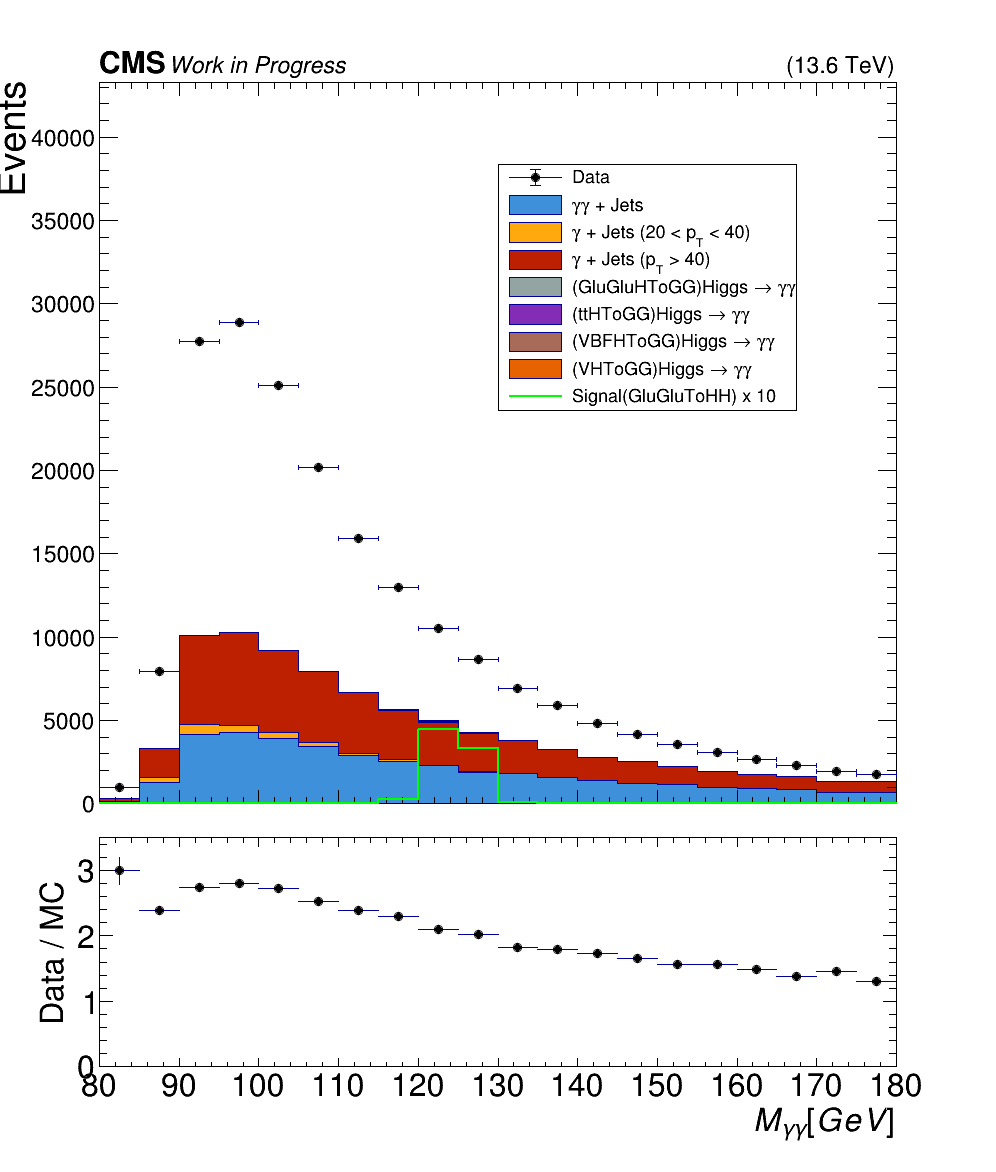

In [9]:
canvas = ROOT.TCanvas("canvas", "Invariant Mass plot", 1000, 1200)

# Adjust canvas to include ratio plot
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.02)  # join pad1 and pad2
pad1.SetTopMargin(0.1)  # increase the top margin
pad1.SetTicks(1, 1)
pad1.Draw()
pad1.cd()

# Draw the background histograms
stack = ROOT.THStack("stack", " ")
for bg_name, bg_hist in background_hists.items():
    stack.Add(bg_hist)

# Draw the stack
stack.Draw("HIST")

# Create a histogram for data invariant masses
hist_data = ROOT.TH1F("hist_data", "", 20, 80, 180)
for mass in data_invariant_masses:
    hist_data.Fill(mass)

# Set y-axis minimum to 0 and draw the histograms
stack.SetMinimum(0)
max_y = max(stack.GetMaximum(), hist_data.GetMaximum())
stack.SetMaximum(max_y * 1.5)

# Remove x-axis label on the main plot
stack.GetXaxis().SetLabelSize(0)
stack.GetXaxis().SetTitleSize(0)

# Set y-axis label for the main plot
stack.GetYaxis().SetTitle("Events")
stack.GetYaxis().SetTitleSize(0.05)

stack.GetYaxis().SetTitleOffset(1.1)
stack.GetYaxis().SetLabelSize(0.03)


# Draw the stack and data histogram
stack.Draw("HIST")
hist_data.SetMarkerStyle(20)
hist_data.SetMarkerSize(1.2)
hist_data.SetMarkerColor(ROOT.kBlack)
hist_data.Draw("SAME E1")


# Draw signal histogram
signal_hist.Draw("SAME HIST")


# # Add legend
# legend = ROOT.TLegend(0.6, 0.6, 0.8, 0.8)
# legend.AddEntry(hist_data, "Data", "lep")
# for bg_name, bg_hist in background_hists.items():
#     legend.AddEntry(bg_hist, bg_name, "f")
# legend.Draw()

# Add legend
legend = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
legend.AddEntry(hist_data, "Data", "lep")
legend.AddEntry(background_hists["GGJets"], "#gamma#gamma + Jets", "f")
legend.AddEntry(background_hists["GJetPt20To40"], "#gamma + Jets (20 < p_{T} < 40)", "f")
legend.AddEntry(background_hists["GJetPt40"], "#gamma + Jets (p_{T} > 40)", "f")
legend.AddEntry(background_hists["GluGluHToGG"], "(GluGluHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["ttHToGG"], "(ttHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["VBFHToGG"], "(VBFHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["VHToGG"], "(VHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(signal_hist, "Signal(GluGluToHH) x 10", "l")
legend.Draw()

# Draw CMS text
cms_label = ROOT.TLatex()
cms_label.SetNDC()
cms_label.SetTextFont(61)
cms_label.SetTextSize(0.04)
cms_label.DrawLatex(0.1, 0.91, "CMS")

# Draw "Work in Progress"
work_label = ROOT.TLatex()
work_label.SetNDC()
work_label.SetTextFont(52)
work_label.SetTextSize(0.03)
work_label.DrawLatex(0.17, 0.91, "Work in Progress")

# Draw energy information
energy_label = ROOT.TLatex()
energy_label.SetNDC()
energy_label.SetTextFont(42)
energy_label.SetTextSize(0.03)
energy_label.DrawLatex(0.79, 0.91, "(13.6 TeV)")

# Set ticks on all sides with smaller size
stack.GetXaxis().SetTickSize(0.02)
stack.GetYaxis().SetTickSize(0.02)

# Draw ratio plot
canvas.cd()
pad2 = ROOT.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.05)
pad2.SetBottomMargin(0.3)
pad2.SetTicks(1, 1)
pad2.Draw()
pad2.cd()

# Create a histogram for the ratio
hist_ratio = hist_data.Clone("hist_ratio")
mc_hist = stack.GetStack().Last().Clone("mc_hist")

hist_ratio.Divide(mc_hist)
hist_ratio.SetMarkerStyle(20)
hist_ratio.SetMarkerSize(1.2)
hist_ratio.SetMarkerColor(ROOT.kBlack)

# Remove statistics box from the ratio plot
hist_ratio.SetStats(0)

# Increase text size for labels and titles
hist_ratio.GetXaxis().SetLabelSize(0.1)
hist_ratio.GetXaxis().SetTitleSize(0.1)
hist_ratio.GetYaxis().SetLabelSize(0.1)
hist_ratio.GetYaxis().SetTitleSize(0.12)

# Draw the ratio histogram
hist_ratio.Draw("ep")

# Add labels and title for the ratio plot
hist_ratio.GetXaxis().SetTitle("M_{\gamma\gamma} [GeV]")
hist_ratio.GetYaxis().SetLabelSize(0.1)
hist_ratio.GetYaxis().SetTitleSize(0.1)
hist_ratio.GetYaxis().SetTitle("Data / MC")
hist_ratio.GetYaxis().SetTitleOffset(0.30)
hist_ratio.GetYaxis().SetNdivisions(505)
hist_ratio.GetYaxis().SetTickLength(0.02)
hist_ratio.GetYaxis().CenterTitle(True)


# Set y-axis range and divisions
hist_ratio.SetMinimum(0)
hist_ratio.SetMaximum(3.5)  # Adjust maximum as needed
hist_ratio.GetYaxis().SetNdivisions(505)  # Increase divisions for better visibility

# # Draw horizontal lines at each integer point
# for y in range(-10, 11):
#     line = ROOT.TLine(80, y, 180, y)
#     line.SetLineStyle(2)  # Dashed line
#     line.SetLineColor(ROOT.kRed)
#     line.Draw()

# # Save the canvas as a PDF file
canvas.Print("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/Corrected_invariant_mass_diphoton_weights.pdf")

# Show the canvas
canvas.Draw()

# Applying Cuts

In [19]:
def create_lorentz_vector(pt, eta, phi, m):
    lv = ROOT.TLorentzVector()
    lv.SetPtEtaPhiM(pt, eta, phi, m)
    return lv

def process_file(file_path, tree_name):
    # Open the ROOT file in read mode
    file_1 = ROOT.TFile(file_path, "READ")
    tree = file_1.Get(tree_name)

    # Array to store the invariant mass values, genWeights, and weight_central
    invariant_masses = []
    weights = []
    weight_central_values = []

    if not tree:
        print(f"Tree not found in file: {file_path}")
    else:
        for event in tree:
            if not hasattr(event, 'lead_pt') or not hasattr(event, 'lead_eta') or not hasattr(event, 'lead_phi') or not hasattr(event, 'sublead_pt') or not hasattr(event, 'sublead_eta') or not hasattr(event, 'sublead_phi'):
                continue

            lead_pt = event.lead_pt
            lead_eta = event.lead_eta
            lead_phi = event.lead_phi
            sublead_pt = event.sublead_pt
            sublead_eta = event.sublead_eta
            sublead_phi = event.sublead_phi
            lead_mvaID_WP90 = event.lead_mvaID_WP90
            sublead_mvaID_WP90 = event.sublead_mvaID_WP90
            weight = getattr(event, 'weight', 1)  # Use 1 if genWeight is not available
            weight_central = getattr(event, 'weight_central', 1)  # Use 1 if weight_central is not available

            # Check if both photons pass the ID cut
            if lead_mvaID_WP90 != 1 or sublead_mvaID_WP90 != 1:
                continue
                
            # Assume mass of photon to be zero
            photon_mass = 0.0

            # Create Lorentz vectors for the lead and sublead photons
            lv1 = create_lorentz_vector(lead_pt, lead_eta, lead_phi, photon_mass)
            lv2 = create_lorentz_vector(sublead_pt, sublead_eta, sublead_phi, photon_mass)

            # Calculate the total Lorentz vector
            lv = lv1 + lv2

            # Get the invariant mass
            invariant_mass = lv.M()

            # Store the invariant mass, genWeight, and weight_central
            invariant_masses.append(invariant_mass)
            weights.append(weight)
            weight_central_values.append(weight_central)

    # Close the ROOT file
    file_1.Close()

    # Return the invariant mass values, genWeights, and weight_central
    return invariant_masses, weights, weight_central_values

In [20]:
# Process data files
data_invariant_masses = []
for data_file_path in data_file_paths:
    masses, _, _ = process_file(data_file_path, tree_name)  # Ignore the weights
    data_invariant_masses.extend(masses)

In [21]:
#MC 
# Update1 : Process background files and create histograms
background_hists = {}
hex_colors = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
rgb_colors = [(int(h[1:3], 16), int(h[3:5], 16), int(h[5:], 16)) for h in hex_colors]

for i, (background_file, bg_name) in enumerate(background_files):
    bg_invariant_masses, bg_weights, bg_weight_central = process_file(background_file, tree_name)
    bg_hist = ROOT.TH1F(f"hist_{bg_name}", f"{bg_name} Invariant Mass", 20, 80, 180)
    cross_section = cross_sections[bg_name]
    for mass, weight, weight_central in zip(bg_invariant_masses, bg_weights, bg_weight_central):
        adjusted_weight = (weight * 1000* total_integrated_luminosity * cross_section) / weight_central
        bg_hist.Fill(mass, adjusted_weight)
    r, g, b = rgb_colors[i]
    bg_hist.SetFillColor(ROOT.TColor.GetColor(r, g, b))
    background_hists[bg_name] = bg_hist

Warning in <TROOT::Append>: Replacing existing TH1: hist_GGJets (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_GJetPt20To40 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_GJetPt40 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_GluGluHToGG (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_ttHToGG (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_VBFHToGG (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_VHToGG (Potential memory leak).


In [22]:
# Updated: Process signal file and create histogram
signal_invariant_masses, signal_weights, signal_weight_central = process_file(signal_file, tree_name)
signal_hist = ROOT.TH1F("hist_signal", "Signal Invariant Mass", 20, 80, 180)
signal_cross_section = cross_sections["GluGluToHH"]

for mass, weight, weight_central in zip(signal_invariant_masses, signal_weights, signal_weight_central):
    adjusted_weight = (weight * 1000* total_integrated_luminosity * signal_cross_section) / weight_central
    signal_hist.Fill(mass, adjusted_weight)
    


signal_hist.SetLineColor(ROOT.kGreen)
signal_hist.SetLineWidth(2)
signal_hist.Draw("SAME HIST")

Warning in <TROOT::Append>: Replacing existing TH1: hist_signal (Potential memory leak).


In [23]:
signal_hist.Scale(10)

In [25]:
canvas = ROOT.TCanvas("canvas", "Invariant Mass plot", 1000, 1200)

# Adjust canvas to include ratio plot
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.02)  # join pad1 and pad2
pad1.SetTopMargin(0.1)  # increase the top margin
pad1.SetTicks(1, 1)
pad1.Draw()
pad1.cd()

# Draw the background histograms
stack = ROOT.THStack("stack", " ")
for bg_name, bg_hist in background_hists.items():
    stack.Add(bg_hist)

# Draw the stack
stack.Draw("HIST")

# Create a histogram for data invariant masses
hist_data = ROOT.TH1F("hist_data", "", 20, 80, 180)
for mass in data_invariant_masses:
    hist_data.Fill(mass)

# Set y-axis minimum to 0 and draw the histograms
stack.SetMinimum(0)
max_y = max(stack.GetMaximum(), hist_data.GetMaximum())
stack.SetMaximum(max_y * 1.5)

# Remove x-axis label on the main plot
stack.GetXaxis().SetLabelSize(0)
stack.GetXaxis().SetTitleSize(0)

# Set y-axis label for the main plot
stack.GetYaxis().SetTitle("Events")
stack.GetYaxis().SetTitleSize(0.05)

stack.GetYaxis().SetTitleOffset(1.1)
stack.GetYaxis().SetLabelSize(0.03)


# Draw the stack and data histogram
stack.Draw("HIST")
hist_data.SetMarkerStyle(20)
hist_data.SetMarkerSize(1.2)
hist_data.SetMarkerColor(ROOT.kBlack)
hist_data.Draw("SAME E1")


# Draw signal histogram
signal_hist.Draw("SAME HIST")


# # Add legend
# legend = ROOT.TLegend(0.6, 0.6, 0.8, 0.8)
# legend.AddEntry(hist_data, "Data", "lep")
# for bg_name, bg_hist in background_hists.items():
#     legend.AddEntry(bg_hist, bg_name, "f")
# legend.Draw()

# Add legend
legend = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
legend.AddEntry(hist_data, "Data", "lep")
legend.AddEntry(background_hists["GGJets"], "#gamma#gamma + Jets", "f")
legend.AddEntry(background_hists["GJetPt20To40"], "#gamma + Jets (20 < p_{T} < 40)", "f")
legend.AddEntry(background_hists["GJetPt40"], "#gamma + Jets (p_{T} > 40)", "f")
legend.AddEntry(background_hists["GluGluHToGG"], "(GluGluHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["ttHToGG"], "(ttHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["VBFHToGG"], "(VBFHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["VHToGG"], "(VHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(signal_hist, "Signal(GluGluToHH) x 10", "l")
legend.Draw()

# Draw CMS text
cms_label = ROOT.TLatex()
cms_label.SetNDC()
cms_label.SetTextFont(61)
cms_label.SetTextSize(0.04)
cms_label.DrawLatex(0.1, 0.91, "CMS")

# Draw "Work in Progress"
work_label = ROOT.TLatex()
work_label.SetNDC()
work_label.SetTextFont(52)
work_label.SetTextSize(0.03)
work_label.DrawLatex(0.17, 0.91, "Work in Progress")

# Draw energy information
energy_label = ROOT.TLatex()
energy_label.SetNDC()
energy_label.SetTextFont(42)
energy_label.SetTextSize(0.03)
energy_label.DrawLatex(0.79, 0.91, "(13.6 TeV)")

# Set ticks on all sides with smaller size
stack.GetXaxis().SetTickSize(0.02)
stack.GetYaxis().SetTickSize(0.02)

# Draw ratio plot
canvas.cd()
pad2 = ROOT.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.05)
pad2.SetBottomMargin(0.3)
pad2.SetTicks(1, 1)
pad2.Draw()
pad2.cd()

# Create a histogram for the ratio
hist_ratio = hist_data.Clone("hist_ratio")
mc_hist = stack.GetStack().Last().Clone("mc_hist")

hist_ratio.Divide(mc_hist)
hist_ratio.SetMarkerStyle(20)
hist_ratio.SetMarkerSize(1.2)
hist_ratio.SetMarkerColor(ROOT.kBlack)

# Remove statistics box from the ratio plot
hist_ratio.SetStats(0)

# Increase text size for labels and titles
hist_ratio.GetXaxis().SetLabelSize(0.1)
hist_ratio.GetXaxis().SetTitleSize(0.1)
hist_ratio.GetYaxis().SetLabelSize(0.1)
hist_ratio.GetYaxis().SetTitleSize(0.12)

# Draw the ratio histogram
hist_ratio.Draw("ep")

# Add labels and title for the ratio plot
hist_ratio.GetXaxis().SetTitle("M_{\gamma\gamma} [GeV]")
hist_ratio.GetYaxis().SetLabelSize(0.1)
hist_ratio.GetYaxis().SetTitleSize(0.1)
hist_ratio.GetYaxis().SetTitle("Data / MC")
hist_ratio.GetYaxis().SetTitleOffset(0.30)
hist_ratio.GetYaxis().SetNdivisions(505)
hist_ratio.GetYaxis().SetTickLength(0.02)
hist_ratio.GetYaxis().CenterTitle(True)


# Set y-axis range and divisions
hist_ratio.SetMinimum(0)
hist_ratio.SetMaximum(3.5)  # Adjust maximum as needed
hist_ratio.GetYaxis().SetNdivisions(505)  # Increase divisions for better visibility

# # Draw horizontal lines at each integer point
# for y in range(-10, 11):
#     line = ROOT.TLine(80, y, 180, y)
#     line.SetLineStyle(2)  # Dashed line
#     line.SetLineColor(ROOT.kRed)
#     line.Draw()

# # Save the canvas as a PDF file
canvas.Print("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/Corrected_invariant_mass_diphoton_weights_photonID_Cuts.pdf")

# Show the canvas
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist_data (Potential memory leak).
Info in <TCanvas::Print>: pdf file /afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/Corrected_invariant_mass_diphoton_weights_photonID_Cuts.pdf has been created


In [26]:
for i, (background_file, bg_name) in enumerate(background_files):
    bg_invariant_masses, _, _ = process_file(background_file, tree_name)
    
    # Initialize histogram without weights
    bg_hist_no_weights = ROOT.TH1F(f"hist_{bg_name}_no_weights", f"{bg_name} Invariant Mass (No Weights)", 20, 80, 180)
    
    # Fill histogram without weights
    for mass in bg_invariant_masses:
        bg_hist_no_weights.Fill(mass)
    
    # Print number of events in the histogram before adding weights
    print(f"Number of events in histogram for {bg_name} before adding weights: {bg_hist_no_weights.Integral(0,21)}")
    
    # Now, add weights
    bg_invariant_masses, bg_weights, bg_weight_central = process_file(background_file, tree_name)
    bg_hist = ROOT.TH1F(f"hist_{bg_name}", f"{bg_name} Invariant Mass", 20, 80, 180)
    
    cross_section = cross_sections[bg_name]
    
    for mass, weight, weight_central in zip(bg_invariant_masses, bg_weights, bg_weight_central):
        adjusted_weight = (weight * 1000 * total_integrated_luminosity * cross_section) / weight_central
        bg_hist.Fill(mass, adjusted_weight)
    
    r, g, b = rgb_colors[i]
    bg_hist.SetFillColor(ROOT.TColor.GetColor(r, g, b))
    background_hists[bg_name] = bg_hist

    # Print number of events after adding weights
    print(f"Number of events for {bg_name} after adding weights: {bg_hist.Integral(0,21)}")


Number of events in histogram for GGJets before adding weights: 41227.0
Number of events for GGJets after adding weights: 41307.72560882568
Number of events in histogram for GJetPt20To40 before adding weights: 5849.0
Number of events for GJetPt20To40 after adding weights: 1332.0511418282986
Number of events in histogram for GJetPt40 before adding weights: 25170.0
Number of events for GJetPt40 after adding weights: 31063.491065979004
Number of events in histogram for GluGluHToGG before adding weights: 191988.0
Number of events for GluGluHToGG after adding weights: 144.4601793551119
Number of events in histogram for ttHToGG before adding weights: 230009.0
Number of events for ttHToGG after adding weights: 11.621326726861298
Number of events in histogram for VBFHToGG before adding weights: 106163.0
Number of events for VBFHToGG after adding weights: 10.410764061380178
Number of events in histogram for VHToGG before adding weights: 116160.0
Number of events for VHToGG after adding weights:

Warning in <TROOT::Append>: Replacing existing TH1: hist_GGJets (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_GJetPt20To40 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_GJetPt40 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_GluGluHToGG (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_ttHToGG (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_VBFHToGG (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_VHToGG (Potential memory leak).


## Applying blinding 

Applying cuts based on the talk: https://indico.cern.ch/event/1403072/attachments/2865219/5014751/LHCseminarHH20240528RuiZhang.pdf

In [27]:
blind_min = 110
blind_max = 140



In [28]:
for i, (background_file, bg_name) in enumerate(background_files):
    bg_invariant_masses, _, _ = process_file(background_file, tree_name)
    
    # Initialize histogram without weights
    bg_hist_no_weights = ROOT.TH1F(f"hist_{bg_name}_no_weights", f"{bg_name} Invariant Mass (No Weights)", 20, 80, 180)
    
    # Fill histogram without weights
    for mass in bg_invariant_masses:
        bg_hist_no_weights.Fill(mass)
    
    # Print number of events in the histogram before adding weights
    print(f"Number of events in histogram for {bg_name} before adding weights: {bg_hist_no_weights.Integral(0,21)}")
    
    # Now, add weights
    bg_invariant_masses, bg_weights, bg_weight_central = process_file(background_file, tree_name)
    bg_hist = ROOT.TH1F(f"hist_{bg_name}", f"{bg_name} Invariant Mass", 20, 80, 180)
    
    cross_section = cross_sections[bg_name]
    
    for mass, weight, weight_central in zip(bg_invariant_masses, bg_weights, bg_weight_central):
        
        adjusted_weight = (weight * 1000 * total_integrated_luminosity * cross_section) / weight_central
        bg_hist.Fill(mass, adjusted_weight)
    
    r, g, b = rgb_colors[i]
    bg_hist.SetFillColor(ROOT.TColor.GetColor(r, g, b))
    background_hists[bg_name] = bg_hist

    # Print number of events after adding weights
    print(f"Number of events for {bg_name} after adding weights: {bg_hist.Integral(0,21)}")



Number of events in histogram for GGJets before adding weights: 41227.0
Number of events for GGJets after adding weights: 41307.72560882568
Number of events in histogram for GJetPt20To40 before adding weights: 5849.0
Number of events for GJetPt20To40 after adding weights: 1332.0511418282986
Number of events in histogram for GJetPt40 before adding weights: 25170.0
Number of events for GJetPt40 after adding weights: 31063.491065979004
Number of events in histogram for GluGluHToGG before adding weights: 191988.0
Number of events for GluGluHToGG after adding weights: 144.4601793551119
Number of events in histogram for ttHToGG before adding weights: 230009.0
Number of events for ttHToGG after adding weights: 11.621326726861298
Number of events in histogram for VBFHToGG before adding weights: 106163.0
Number of events for VBFHToGG after adding weights: 10.410764061380178
Number of events in histogram for VHToGG before adding weights: 116160.0
Number of events for VHToGG after adding weights:

Warning in <TROOT::Append>: Replacing existing TH1: hist_GGJets (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_GJetPt20To40 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_GJetPt40 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_GluGluHToGG (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_ttHToGG (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_VBFHToGG (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist_VHToGG (Potential memory leak).


In [29]:
# Process signal file
signal_invariant_masses, _, _ = process_file(signal_file, tree_name)

# Initialize histogram without weights for signal
signal_hist_no_weights = ROOT.TH1F("hist_signal_no_weights", "Signal Invariant Mass (No Weights)", 20, 80, 180)

# Fill histogram without weights for signal
for mass in signal_invariant_masses:
    signal_hist_no_weights.Fill(mass)

# Print number of events in the histogram before adding weights for signal
print(f"Number of events in histogram for signal before adding weights: {signal_hist_no_weights.Integral(0,21)}")

# Now, add weights for signal
signal_invariant_masses, signal_weights, signal_weight_central = process_file(signal_file, tree_name)
signal_hist = ROOT.TH1F("hist_signal", "Signal Invariant Mass", 20, 80, 180)

signal_cross_section = cross_sections["GluGluToHH"]

for mass, weight, weight_central in zip(signal_invariant_masses, signal_weights, signal_weight_central):
    adjusted_weight = (weight * 1000 * total_integrated_luminosity * signal_cross_section) / weight_central
    signal_hist.Fill(mass, adjusted_weight)

signal_hist.SetLineColor(ROOT.kGreen)
signal_hist.SetLineWidth(2)
signal_hist.Draw("SAME HIST")

# Print number of events after adding weights for signal
print(f"Number of events for signal after adding weights: {signal_hist.Integral(0,21)}")


Number of events in histogram for signal before adding weights: 118317.0
Number of events for signal after adding weights: 737.3370916754939


Warning in <TROOT::Append>: Replacing existing TH1: hist_signal (Potential memory leak).


In [30]:
signal_hist.Scale(10)

In [31]:
canvas = ROOT.TCanvas("canvas", "Invariant Mass plot", 1000, 1200)

# Adjust canvas to include ratio plot
pad1 = ROOT.TPad("pad1", "pad1", 0, 0.3, 1, 1.0)
pad1.SetBottomMargin(0.02)  # join pad1 and pad2
pad1.SetTopMargin(0.1)  # increase the top margin
pad1.SetTicks(1, 1)
pad1.Draw()
pad1.cd()

# Draw the background histograms
stack = ROOT.THStack("stack", " ")
for bg_name, bg_hist in background_hists.items():
    stack.Add(bg_hist)

# Draw the stack
stack.Draw("HIST")

# Initialize histogram for data with blinding
hist_data = ROOT.TH1F("hist_data", "", 20, 80, 180)
for mass in data_invariant_masses:
    # Apply blinding
    if blind_min < mass < blind_max:
        continue
    hist_data.Fill(mass)

# Set y-axis minimum to 0 and draw the histograms
stack.SetMinimum(0)
max_y = max(stack.GetMaximum(), hist_data.GetMaximum())
stack.SetMaximum(max_y * 1.5)

# Remove x-axis label on the main plot
stack.GetXaxis().SetLabelSize(0)
stack.GetXaxis().SetTitleSize(0)

# Set y-axis label for the main plot
stack.GetYaxis().SetTitle("Events")
stack.GetYaxis().SetTitleSize(0.05)

stack.GetYaxis().SetTitleOffset(1.1)
stack.GetYaxis().SetLabelSize(0.03)


# Draw the stack and data histogram
stack.Draw("HIST")
hist_data.SetMarkerStyle(20)
hist_data.SetMarkerSize(1.2)
hist_data.SetMarkerColor(ROOT.kBlack)
hist_data.Draw("SAME E1")


# Draw signal histogram
signal_hist.Draw("SAME HIST")


# # Add legend
# legend = ROOT.TLegend(0.6, 0.6, 0.8, 0.8)
# legend.AddEntry(hist_data, "Data", "lep")
# for bg_name, bg_hist in background_hists.items():
#     legend.AddEntry(bg_hist, bg_name, "f")
# legend.Draw()

# Add legend
legend = ROOT.TLegend(0.5, 0.5, 0.8, 0.8)
legend.AddEntry(hist_data, "Data", "lep")
legend.AddEntry(background_hists["GGJets"], "#gamma#gamma + Jets", "f")
legend.AddEntry(background_hists["GJetPt20To40"], "#gamma + Jets (20 < p_{T} < 40)", "f")
legend.AddEntry(background_hists["GJetPt40"], "#gamma + Jets (p_{T} > 40)", "f")
legend.AddEntry(background_hists["GluGluHToGG"], "(GluGluHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["ttHToGG"], "(ttHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["VBFHToGG"], "(VBFHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(background_hists["VHToGG"], "(VHToGG)Higgs #rightarrow #gamma#gamma", "f")
legend.AddEntry(signal_hist, "Signal(GluGluToHH) x 10", "l")
legend.Draw()

# Draw CMS text
cms_label = ROOT.TLatex()
cms_label.SetNDC()
cms_label.SetTextFont(61)
cms_label.SetTextSize(0.04)
cms_label.DrawLatex(0.1, 0.91, "CMS")

# Draw "Work in Progress"
work_label = ROOT.TLatex()
work_label.SetNDC()
work_label.SetTextFont(52)
work_label.SetTextSize(0.03)
work_label.DrawLatex(0.17, 0.91, "Work in Progress")

# Draw energy information
energy_label = ROOT.TLatex()
energy_label.SetNDC()
energy_label.SetTextFont(42)
energy_label.SetTextSize(0.03)
energy_label.DrawLatex(0.79, 0.91, "(13.6 TeV)")

# Set ticks on all sides with smaller size
stack.GetXaxis().SetTickSize(0.02)
stack.GetYaxis().SetTickSize(0.02)

# Draw ratio plot
canvas.cd()
pad2 = ROOT.TPad("pad2", "pad2", 0, 0, 1, 0.3)
pad2.SetTopMargin(0.05)
pad2.SetBottomMargin(0.3)
pad2.SetTicks(1, 1)
pad2.Draw()
pad2.cd()

# Create a histogram for the ratio
hist_ratio = hist_data.Clone("hist_ratio")
mc_hist = stack.GetStack().Last().Clone("mc_hist")

hist_ratio.Divide(mc_hist)
hist_ratio.SetMarkerStyle(20)
hist_ratio.SetMarkerSize(1.2)
hist_ratio.SetMarkerColor(ROOT.kBlack)

# Remove statistics box from the ratio plot
hist_ratio.SetStats(0)

# Increase text size for labels and titles
hist_ratio.GetXaxis().SetLabelSize(0.1)
hist_ratio.GetXaxis().SetTitleSize(0.1)
hist_ratio.GetYaxis().SetLabelSize(0.1)
hist_ratio.GetYaxis().SetTitleSize(0.12)

# Draw the ratio histogram
hist_ratio.Draw("ep")

# Add labels and title for the ratio plot
hist_ratio.GetXaxis().SetTitle("M_{\gamma\gamma} [GeV]")
hist_ratio.GetYaxis().SetLabelSize(0.1)
hist_ratio.GetYaxis().SetTitleSize(0.1)
hist_ratio.GetYaxis().SetTitle("Data / MC")
hist_ratio.GetYaxis().SetTitleOffset(0.30)
hist_ratio.GetYaxis().SetNdivisions(505)
hist_ratio.GetYaxis().SetTickLength(0.02)
hist_ratio.GetYaxis().CenterTitle(True)


# Set y-axis range and divisions
hist_ratio.SetMinimum(0)
hist_ratio.SetMaximum(3.5)  # Adjust maximum as needed
hist_ratio.GetYaxis().SetNdivisions(505)  # Increase divisions for better visibility

# # Draw horizontal lines at each integer point
# for y in range(-10, 11):
#     line = ROOT.TLine(80, y, 180, y)
#     line.SetLineStyle(2)  # Dashed line
#     line.SetLineColor(ROOT.kRed)
#     line.Draw()

# # Save the canvas as a PDF file
canvas.Print("/afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/Corrected_invariant_mass_diphoton_weights_photonID_Cuts_blinding.pdf")

# Show the canvas
canvas.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Warning in <TROOT::Append>: Replacing existing TH1: hist_data (Potential memory leak).
Info in <TCanvas::Print>: pdf file /afs/cern.ch/user/s/sraj/sraj/www/CUA/HH-bbgg/Corrected_invariant_mass_diphoton_weights_photonID_Cuts_blinding.pdf has been created
